In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

In [2]:
train_dir = '../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/train'
test_dir = '../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/val'

In [3]:
trainfinal=pd.read_csv('../input/fitzpatrick-classification-by-ethnicity/fitz_undersampled_train_final.csv')
trainfinal

,file,age,gender,race,phototype
0,1.jpg,50-59,Male,East Asian,III
1,10.jpg,30-39,Male,Middle Eastern,V
2,100.jpg,20-29,Female,East Asian,III
3,1000.jpg,30-39,Male,White,I & II
4,10004.jpg,40-49,Male,Indian,V
...,...,...,...,...,...
35425,9659.jpg,30-39,Female,Black,VI
35426,967.jpg,40-49,Female,Black,VI
35427,9676.jpg,30-39,Female,Black,VI
35428,9703.jpg,20-29,Female,Black,VI


In [4]:
testfinal=pd.read_csv('../input/fitzpatrick-classification-by-ethnicity/fitz_undersampled_test_final.csv')
testfinal

,file,age,gender,race,phototype
0,100.jpg,20-29,Female,East Asian,III
1,1000.jpg,20-29,Male,Latino_Hispanic,IV
2,10000.jpg,20-29,Female,East Asian,III
3,10001.jpg,20-29,Female,Southeast Asian,V
4,10004.jpg,20-29,Male,Southeast Asian,V
...,...,...,...,...,...
4510,9476.jpg,30-39,Female,Black,VI
4511,9501.jpg,40-49,Female,Black,VI
4512,9560.jpg,30-39,Female,Black,VI
4513,9561.jpg,20-29,Female,Black,VI


In [5]:
Name = trainfinal['phototype'].unique().tolist()
print(Name)
print(len(Name))

['III', 'V', 'I & II', 'IV', 'VI']
5


In [6]:
Class_count_1, Class_count_2, Class_count_3, Class_count_4,Class_count_5= trainfinal['phototype'].value_counts()
# Separate class
Class_count_1 = trainfinal[trainfinal['phototype'] == "I & II"]
Class_count_2 = trainfinal[trainfinal['phototype'] == "III"]
Class_count_3 = trainfinal[trainfinal['phototype'] == "IV"]
Class_count_4 = trainfinal[trainfinal['phototype'] == "V"]
Class_count_5 = trainfinal[trainfinal['phototype'] == "VI"]# print the shape of the class
print('class 1:', Class_count_1.shape)
print('class 2:', Class_count_2.shape)
print('class 3:', Class_count_3.shape)
print('class 4:', Class_count_4.shape)
print('class 5:', Class_count_5.shape)

class 1: (7086, 5)
class 2: (7086, 5)
class 3: (7086, 5)
class 4: (7086, 5)
class 5: (7086, 5)


In [7]:
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

In [8]:
trainfinal['phototype2']=trainfinal['phototype'].map(normal_mapping)
testfinal['phototype2']=testfinal['phototype'].map(normal_mapping)

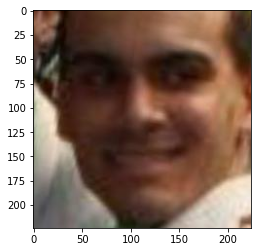

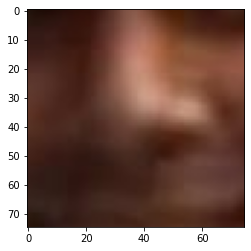

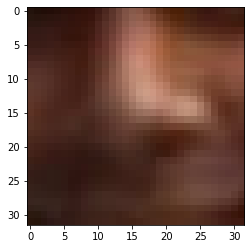

In [9]:
path0='../input/fitzpatrick-classification-by-ethnicity/fairface/fairface/train/10006.jpg'
image=cv2.imread(path0)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()
sp=image.shape

image2=image[(sp[0]//3):(sp[0]*2//3),(sp[1]//3):(sp[1]*2//3),:]
plt.imshow(cv2.cvtColor(image2,cv2.COLOR_BGR2RGB))
plt.show()

image3=cv2.resize(image2,(32,32)) 
#image3=cv2.resize(image2,dsize=(32,32),interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(image3,cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
trainX=[]
trainY0=[]
for im in tqdm(os.listdir(train_dir)[0:5000]):
    image=cv2.imread(os.path.join(train_dir,im))
    if im[-4:]=='.jpg':
        lists=trainfinal[trainfinal['file']==im]['phototype2'].tolist()
        if len(lists)==1:
            count=lists[0]
            sp=image.shape
            image2=image[(sp[0]//3):(sp[0]*2//3),(sp[1]//3):(sp[1]*2//3),:]
            image3=cv2.resize(image2,(32,32))
            trainX+=[image3]
            trainY0+=[count]

100%|██████████| 5000/5000 [00:48<00:00, 102.73it/s]


In [11]:
testX=[]
testY0=[]
for im in tqdm(os.listdir(test_dir)):
    image=cv2.imread(os.path.join(test_dir,im))
    if im[-4:]=='.jpg':
        lists=testfinal[testfinal['file']==im]['phototype2'].tolist()
        if len(lists)==1:
            count=lists[0]
            image2=image[(sp[0]//3):(sp[0]*2//3),(sp[1]//3):(sp[1]*2//3),:]
            image3=cv2.resize(image2,(32,32))
            testX+=[image3]
            testY0+=[count]

100%|██████████| 4535/4535 [00:24<00:00, 181.68it/s]


In [12]:
labels1=to_categorical(trainY0)
trainY=np.array(labels1)

In [13]:
trainX=np.array(trainX)
testX=np.array(testX)

In [14]:
trainx,testx,trainy,testy=train_test_split(trainX,trainY,test_size=0.2,random_state=44)

In [15]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [16]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(32,32,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74842112/74836368 [==============================] - 4s 0us/step


In [17]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(len(Name), activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=100)

Epoch 1/100
125/125 [==============================] - 26s 80ms/step - loss: 2.1609 - accuracy: 0.2455 - val_loss: 1.5972 - val_accuracy: 0.3013
Epoch 2/100
125/125 [==============================] - 6s 46ms/step - loss: 1.5932 - accuracy: 0.3266 - val_loss: 1.5618 - val_accuracy: 0.3253
Epoch 3/100
125/125 [==============================] - 6s 51ms/step - loss: 1.5684 - accuracy: 0.3149 - val_loss: 1.5691 - val_accuracy: 0.3153
Epoch 4/100
125/125 [==============================] - 6s 45ms/step - loss: 1.5408 - accuracy: 0.3175 - val_loss: 1.5626 - val_accuracy: 0.3163
Epoch 5/100
125/125 [==============================] - 6s 45ms/step - loss: 1.4964 - accuracy: 0.3578 - val_loss: 1.5346 - val_accuracy: 0.3243
Epoch 6/100
125/125 [==============================] - 6s 48ms/step - loss: 1.5099 - accuracy: 0.3293 - val_loss: 1.5074 - val_accuracy: 0.3303
Epoch 7/100
125/125 [==============================] - 6s 49ms/step - loss: 1.4933 - accuracy: 0.3428 - val_loss: 1.5314 - val_accuracy

In [20]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.29      0.41      0.34       196
           1       0.30      0.17      0.22       209
           2       0.37      0.23      0.29       188
           3       0.26      0.37      0.30       197
           4       0.46      0.46      0.46       209

    accuracy                           0.33       999
   macro avg       0.34      0.33      0.32       999
weighted avg       0.34      0.33      0.32       999



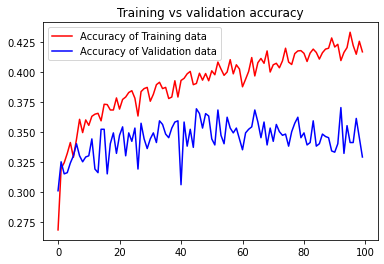

<Figure size 432x288 with 0 Axes>

In [21]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

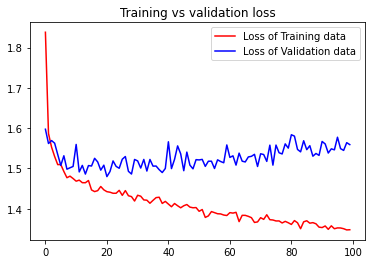

<Figure size 432x288 with 0 Axes>

In [22]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [23]:
pred2=model.predict(testX)
print(pred2.shape)

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(pd.Series(PRED).value_counts())

(4515, 5)
0    1319
3    1181
4     974
1     534
2     507
dtype: int64


In [24]:
ANS=testY0
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.3444075304540421


In [25]:
m=len(testX)
M=list(range(m))
random.seed(2021)
random.shuffle(M)

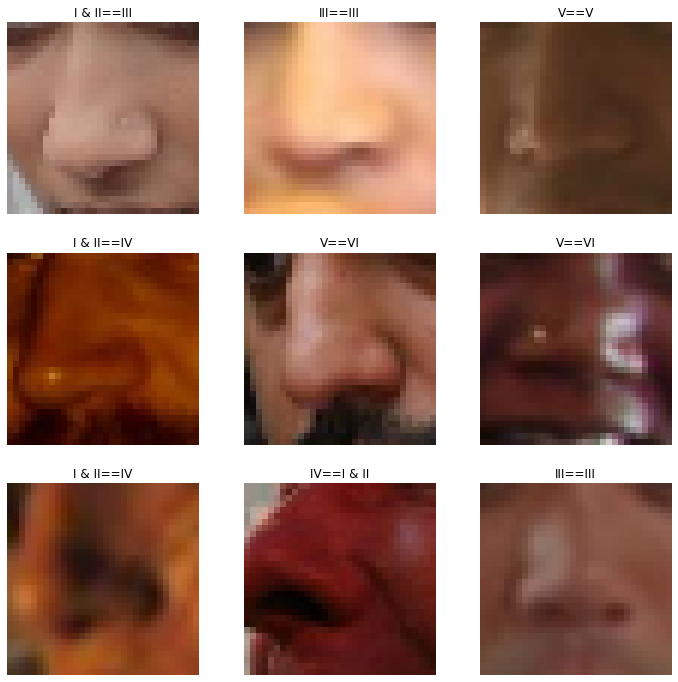

In [26]:
fig, axs = plt.subplots(3,3,figsize=(12,12))
for i in range(9):
    r=i//3
    c=i%3
    img1 = testX[M[i]]
    ax=axs[r][c].axis("off")
    actual=reverse_mapping[testY0[M[i]]]
    predict=reverse_mapping[PRED[M[i]]]    
    ax=axs[r][c].set_title(actual+'=='+predict)
    ax=axs[r][c].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()